In [2]:
# multivariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Activation


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from math import sqrt
from matplotlib import pyplot
from numpy import array
import numpy as np
from keras.layers import LSTM , CuDNNLSTM
import matplotlib.pyplot as plt
import pandas as pd
sns.set()

In [3]:
cd electric_time_series/

/mlsteam/lab/electric_time_series


Load the file

In [128]:
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
dataset = dataset.reset_index()

In [129]:
dataset[['datetime']] = dataset[['datetime']].astype(str)


In [130]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
datetime                 object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
sub_metering_4           float64
dtypes: float64(8), object(1)
memory usage: 142.5+ MB


In [131]:
dataset.isnull().sum()

datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
dtype: int64

In [132]:
dataset = dataset.drop(['datetime'], axis=1)


In [133]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [134]:
dataset.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
Global_active_power,1.000000,0.247088,-0.396853,0.998884,0.484110,0.434012,0.638966,0.700756
Global_reactive_power,0.247088,1.000000,-0.110802,0.266219,0.123006,0.139321,0.089949,0.211442
Voltage,-0.396853,-0.110802,1.000000,-0.408480,-0.195018,-0.165702,-0.265935,-0.269298
Global_intensity,0.998884,0.266219,-0.408480,1.000000,0.489027,0.439780,0.626952,0.702647
Sub_metering_1,0.484110,0.123006,-0.195018,0.489027,1.000000,0.054468,0.101996,0.124699
Sub_metering_2,0.434012,0.139321,-0.165702,0.439780,0.054468,1.000000,0.081440,0.084800
Sub_metering_3,0.638966,0.089949,-0.265935,0.626952,0.101996,0.081440,1.000000,0.177762
sub_metering_4,0.700756,0.211442,-0.269298,0.702647,0.124699,0.084800,0.177762,1.000000


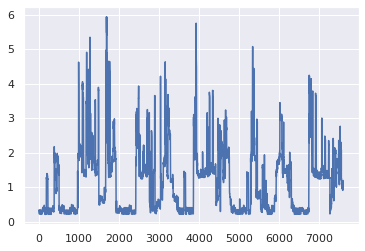

In [136]:
plt_elec_data = dataset['Global_active_power'][-245*31:].values
plt.plot(plt_elec_data)

In [137]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [139]:
# configure
n_lag = 60
look_back = n_lag
n_seq = 10
pred_length = n_seq
features = 8
n_neurons = 64
n_batch = 24

In [140]:
#multivariate
seq2seq_raw_values = dataset.values
test_value = seq2seq_raw_values[:,0].reshape(len(seq2seq_raw_values),1)
# rescale values to -1, 1
scaler_trans = MinMaxScaler(feature_range=(-1, 1))
transfor_fun = scaler_trans.fit_transform(test_value)
# rescale values to -1, 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(seq2seq_raw_values)
########################
#scaled_values = seq2seq_raw_values
#print(scaled_values[:27])
# transform into supervised learning problem X, y
supervised = series_to_supervised(scaled_values, n_lag, n_seq)
supervised_values = supervised.values
supervised_values.shape
train, test = supervised_values[-245*30:-245*1], supervised_values[-245*1:]

print('train',train.shape)
print('test',test.shape)

train (7105, 560)
test (245, 560)


In [141]:
encoder_input_data , decoder_target_data = train[: , :n_lag*features] , train[:, n_lag*features:]
decoder_target_data = decoder_target_data[: , ::features]
encoder_input_data = encoder_input_data.reshape((encoder_input_data.shape[0], n_lag, features))
#decoder_target_data = decoder_target_data.reshape((decoder_target_data.shape[0],decoder_target_data.shape[1],1))
print("encoder_input_data",encoder_input_data.shape,"decoder_target_data",decoder_target_data.shape)

encoder_input_data (7105, 60, 8) decoder_target_data (7105, 10)


In [142]:
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(encoder_input_data.shape[1], encoder_input_data.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=8, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(pred_length))
#model.add(TimeDistributed(Dense(16)))
model.add(Bidirectional(CuDNNLSTM(8,  return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(8)))
model.add(Dense(8))
model.add(Dropout(0.5))
model.add(Dense(pred_length))
#model.add(TimeDistributed(Dense(32, activation='relu')))
#model.add(TimeDistributed(Dense(10, activation='relu')))
#model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')


In [143]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_77 (Conv1D)           (None, 58, 8)             200       
_________________________________________________________________
max_pooling1d_77 (MaxPooling (None, 29, 8)             0         
_________________________________________________________________
conv1d_78 (Conv1D)           (None, 27, 8)             200       
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 13, 8)             0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 104)               0         
_________________________________________________________________
repeat_vector_33 (RepeatVect (None, 10, 104)           0         
_________________________________________________________________
bidirectional_59 (Bidirectio (None, 10, 16)          

In [144]:
history = model.fit(encoder_input_data,
                  decoder_target_data,
                  n_batch,
                  nb_epoch=300,
                  validation_split=0.1,
                  verbose=1)    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 6394 samples, validate on 711 samples
Epoch 1/300
6394/6394 [==============================] - 13s 2ms/step - loss: 0.2504 - val_loss: 0.0327
Epoch 2/300
6394/6394 [==============================] - 6s 895us/step - loss: 0.0906 - val_loss: 0.0205
Epoch 3/300
6394/6394 [==============================] - 6s 894us/step - loss: 0.0544 - val_loss: 0.0165
Epoch 4/300
6394/6394 [==============================] - 6s 861us/step - loss: 0.0378 - val_loss: 0.0149
Epoch 5/300
6394/6394 [==============================] - 5s 854us/step - loss: 0.0271 - val_loss: 0.0138
Epoch 6/300
6394/6394 [==============================] - 6s 876us/step - loss: 0.0205 - val_loss: 0.0131
Epoch 7/300
6394/6394 [==============================] - 6s 881us/step - loss: 0.0165 - val_loss: 0.0123
Epoch 8/300
6394/6394 [==============================] - 6s 873us/step - loss: 0.0142 - val_loss: 0.0123
Epoch 9/300
6394/6394 [==============================] - 6s 877us/step - loss: 0.0131 - val_loss: 0.0122
Epoch 10/

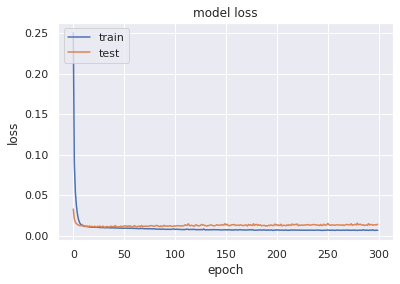

In [145]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Testing data 

In [146]:
test_encoder_input_data , test_output_seq = test[: , :n_lag*features] , test[:, n_lag*features:]
test_output_seq = test_output_seq[: , ::features]
test_encoder_input_data = test_encoder_input_data.reshape((test_encoder_input_data.shape[0], n_lag, features))
test_output_seq = test_output_seq.reshape((test_output_seq.shape[0],test_output_seq.shape[1],1))
print("test_encoder_input_data",test_encoder_input_data.shape,"test_output_seq",test_output_seq.shape)

test_encoder_input_data (245, 60, 8) test_output_seq (245, 10, 1)


In [147]:
forecasts = model.predict(test_encoder_input_data)
forecasts.shape

(245, 10)

In [148]:
forecasts_BBBB=list()
for i in range(len(forecasts)):
    forecasts_BBBB.append(forecasts[i,:])
	
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	b = np.array([0.0])
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + b)
	return inverted
	
import numpy as np
forecast_pred = list()
for i in range(len(forecasts)):
	# create array from forecast
	forecast = array(forecasts_BBBB[i])
	forecast = forecast.reshape(1, len(forecast))
	# invert scaling
	inv_scale = scaler_trans.inverse_transform(forecast)
	inv_scale = inv_scale[0, :]
	# invert differencing
	#index = len(series) - n_test + i - 1
	last_ob = np.array([0.0])
	inv_diff = inverse_difference(last_ob, inv_scale)
	# store
	forecast_pred.append(inv_diff)

forecast_14steps = forecast_pred
actual = [row[:] for row in test_output_seq]
actual_value = list()
for i in range(len(actual)):
	# create array from forecast
	forecast = array(actual[i])
	forecast = forecast.reshape(1, len(forecast))
	# invert scaling
	inv_scale = scaler_trans.inverse_transform(forecast)
	inv_scale = inv_scale[0, :]
	# invert differencing
	#index = len(series) - n_test + i - 1
	last_ob = np.array([0.0])
	inv_diff = inverse_difference(last_ob, inv_scale)
	# store
	actual_value.append(inv_diff)
 

In [149]:
#7day
day = n_seq
actual_np = np.zeros(len(forecast_14steps))
print(actual_np.shape)
#c = 0
#abc[0] = actual_value[6][0]
for i in range(0,len(forecast_14steps),day):
    if (i+day) <= (len(forecast_14steps)):
        for j in range(day):
            #print('i=',i,'j=',j,'i+j=',i+j)
            if (i/day)< (len(forecast_14steps)/day) :
                actual_np[j+i] = actual_value[i+day-1][j]
                #print(actual_value[i+day-1][j])
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
            elif (i/day)==(len(forecast_14steps)/day) and j>=day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day):
                actual_np[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))] = actual_value[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))][-1]
                #print(actual_value[i+day-1][j])
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
    else:
        #print('i=',i,print(actual_np))
        
        for j in range(len(test)%day):
            #print(actual_np[i+j])
            #print(actual_value[-1][j-5])
            actual_np[i+j] = actual_value[-1][j-(len(test)%day)]
            #actual_np[i+j] = actual_value[-1][j+1]
        
            
#print(actual_np)

(245,)


In [150]:
pred_np = np.zeros(len(forecast_14steps))
#c = 0
#abc[0] = actual_value[6][0]
for i in range(0,len(forecast_14steps),day):
    if (i+day) <= (len(forecast_14steps)):
        for j in range(day):
            if (i/day)< (len(forecast_14steps)/day) :
                pred_np[j+i] = forecast_14steps[i+day-1][j]
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
            elif (i/day)==(len(forecast_14steps)/day) and j>=day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day):
                pred_np[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))] = forecast_14steps[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))][-1]
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
    else:
        for j in range(len(test)%day):
            pred_np[i+j] = forecast_14steps[-1][j-(len(test)%day)]

In [151]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(actual_np, pred_np))
print('RMSE: %.3f' % rmse)

RMSE: 0.535


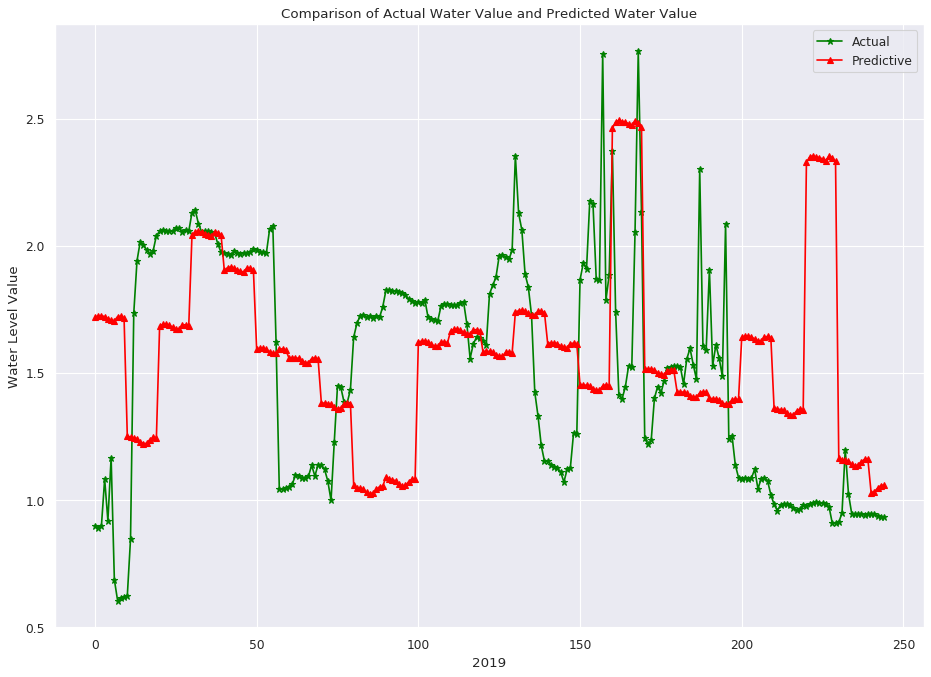

In [153]:
x_axis = np.arange(len(test))
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Comparison of Actual Water Value and Predicted Water Value')
plt.plot(actual_np,'*-', color='green', label='Actual')
plt.plot(pred_np, '^-', color='red', label='Predictive')
plt.legend() # 显示图例
plt.xlabel('2019')
plt.ylabel('Water Level Value')
plt.show()